In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers, callbacks
from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split

In [3]:
data = fetch_openml('Kuzushiji-MNIST')

In [4]:
X, t = data.data.to_numpy(), data.target.to_numpy()
X = X/255. # accomplishes the scaling
X = X.reshape((70000,28,28))
t = t.astype(np.uint8)

(-0.5, 27.5, 27.5, -0.5)

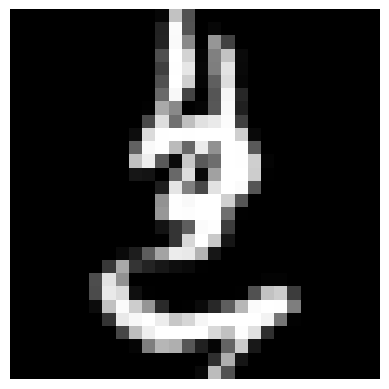

In [5]:
plt.imshow(X[34566], cmap='gray')
plt.axis('off')

In [6]:
X_train, X_test, t_train, t_test = X[:60000], X[60000:], t[:60000], t[60000:]
X_train, X_val, t_train, t_val = train_test_split(X_train, t_train, 
                                                  test_size = 0.20,
                                                  stratify = t_train)

[0 1 2 3 4 5 6 7 8 9]


In [7]:
# Hyperparameters to tune: learning rate, beta values, bottleneck size, 
lr = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.1]
B1 = 0.9
B2 = 0.999
bottleneck = [10, 20, 50, 75, 100, 150]

scores = np.zeros((len(lr), len(bottleneck)))


In [8]:
for ii in range(len(bottleneck)):
    for jj in range(len(lr)):
        encoder = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneck[ii],  activation='relu', use_bias=False)
        ])

        decoder = models.Sequential([
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(28*28, use_bias=False),
            layers.Reshape([28, 28])
        ])

        autoencoder = models.Sequential([encoder, decoder])

        autoencoder.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                            optimizer=optimizers.Adam(learning_rate=lr[jj],
                            beta_1=B1,
                            beta_2=B2))
        
        callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = autoencoder.fit(X_train, X_train, epochs=50, 
                    validation_data=(X_val, X_val),
                    callbacks=callback1,
                    verbose=0)
        
        scores[jj, ii] = min(history.history['val_loss'])

[[0.04249164 0.03525585 0.02253702 0.01951487 0.01522942 0.01251961]
 [0.04520201 0.04209278 0.02456158 0.02129487 0.01721106 0.01506899]
 [0.05015729 0.04478853 0.03866655 0.03007285 0.02549366 0.01981711]
 [0.10356781 0.05747346 0.04741404 0.04920116 0.04683822 0.04481837]
 [0.15787391 0.15787391 0.06875715 0.06581151 0.06265363 0.06312589]
 [0.15787391 0.15787391 0.15787391 0.07219572 0.07210179 0.07317673]
 [0.15787391 0.15787391 0.15787391 0.15787391 0.15787391 0.15787391]]


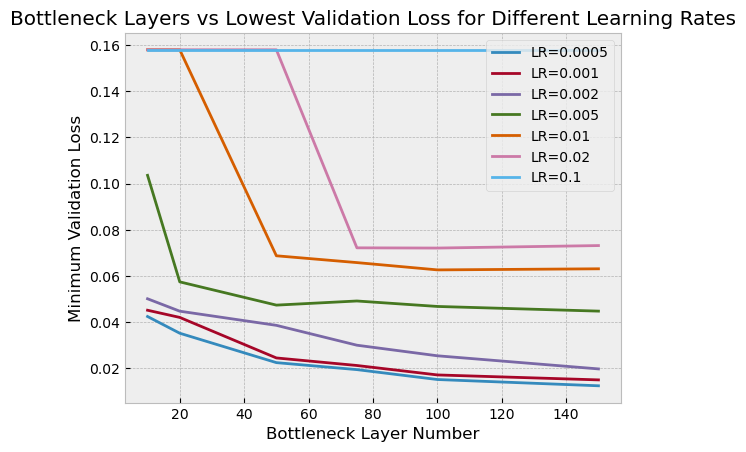

In [9]:
print(scores)
plt.figure()
plt.title('Bottleneck Layers vs Lowest Validation Loss for Different Learning Rates')
plt.plot(bottleneck, scores[0,:], label='LR=0.0005')
plt.plot(bottleneck, scores[1,:], label='LR=0.001')
plt.plot(bottleneck, scores[2,:], label='LR=0.002')
plt.plot(bottleneck, scores[3,:], label='LR=0.005')
plt.plot(bottleneck, scores[4,:], label='LR=0.01')
plt.plot(bottleneck, scores[5,:], label='LR=0.02')
plt.plot(bottleneck, scores[6,:], label='LR=0.1')
plt.xlabel('Bottleneck Layer Number')
plt.ylabel('Minimum Validation Loss')
plt.legend()

# Tuning loss rate and bottleneck layers
As expected, since ADAM helps learning overcome small local minimas, the validation loss in image reconstruction decreases with decreasing learning rate, as long as enough training time is given. Somewhat unexpected is how much increasing the number of nodes in the bottleneck layer increases performance. In PCA, to keep 99.9% of the explained variance of each image, only 16 dimensions are needed on average. But we continue to see much better berformance as we increase bottleneck layer nodes up to 150. The lowest value is in the corner of our grid, but for training time purposes, we will keep the learning rate at 0.0005 as lower learning rates may need many more iterations to properly train. We will now check more units in the bottleneck layer to see where we no longer gain extra performance

In [20]:
bottleneckNum  = [125, 150, 200, 250, 300, 350, 400]
scores2 = np.zeros(len(bottleneckNum))
lr = 0.0005

for ii in range(len(bottleneck)):
    
    encoder = models.Sequential([
        layers.Flatten(input_shape=[28,28]),
        layers.Dense(800,  activation='relu', use_bias=False),
        layers.Dense(200,  activation='relu', use_bias=False),
        layers.Dense(bottleneckNum[ii],  activation='relu', use_bias=False)
    ])

    decoder = models.Sequential([
        layers.Dense(200,  activation='relu', use_bias=False),
        layers.Dense(800,  activation='relu', use_bias=False),
        layers.Dense(28*28, use_bias=False),
        layers.Reshape([28, 28])
    ])

    autoencoder = models.Sequential([encoder, decoder])

    autoencoder.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                        optimizer=optimizers.Adam(learning_rate=lr,
                        beta_1=B1,
                        beta_2=B2))
    
    callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = autoencoder.fit(X_train, X_train, epochs=100, 
                validation_data=(X_val, X_val),
                callbacks=callback1,
                verbose=0)
        
    scores2[ii] = min(history.history['val_loss'])

[0.01213735 0.01158006 0.00972538 0.0102109  0.00936456 0.00923875
 0.00920107]


Text(0, 0.5, 'Minimum Validation Loss')

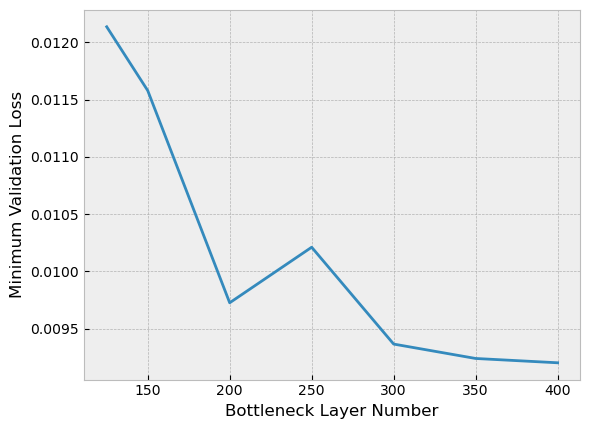

In [21]:
print(scores2)
plt.figure()
plt.plot(bottleneckNum, scores2)
plt.xlabel('Bottleneck Layer Number')
plt.ylabel('Minimum Validation Loss')


In [22]:
# Tune the beta hyperparameters for adam to possibly increase convergence rate. Beta values need to be less than 1
bottleneckNum  = 200

lr = 0.0005
B1 = [0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975]
B2 = [0.995, 0.996, 0.997, 0.998, 0.999]
scores2 = np.zeros((len(B1),len(B2)))
numIter = np.zeros((len(B1),len(B2)))

for ii in range(len(B1)):
    
    for jj in range(len(B2)):
    
        encoder = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneckNum,  activation='relu', use_bias=False)
        ])

        decoder = models.Sequential([
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(28*28, use_bias=False),
            layers.Reshape([28, 28])
        ])

        autoencoder = models.Sequential([encoder, decoder])

        autoencoder.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                            optimizer=optimizers.Adam(learning_rate=lr,
                            beta_1=B1[ii],
                            beta_2=B2[jj]))
        
        callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = autoencoder.fit(X_train, X_train, epochs=100, 
                    validation_data=(X_val, X_val),
                    callbacks=callback1,
                    verbose=0)
             
        scores2[ii, jj] = min(history.history['val_loss'])
        numIter[ii, jj] = len(history.history['val_loss'])

In [26]:
# print(scores2)
# print(numIter)
print(scores2.shape)
print(np.argmin(scores2))

print('Lowest Val loss was with beta 1 = ', B1[2], ' and beta 2 = ', B2[2])

(7, 5)
12
Lowest Val loss was with beta 1 =  0.875  and beta 2 =  0.997


In [27]:
# Train Final Base SAE
bottleneckNum  = 200
lr = 0.0005
B1 = 0.875
B2 = 0.997

encoder = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneckNum,  activation='relu', use_bias=False)
        ])

decoder = models.Sequential([
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(28*28, use_bias=False),
    layers.Reshape([28, 28])
])

autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                    optimizer=optimizers.Adam(learning_rate=lr,
                    beta_1=B1,
                    beta_2=B2))

callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

historySAE = autoencoder.fit(X_train, X_train, epochs=100, 
            validation_data=(X_val, X_val),
            callbacks=callback1,
            verbose=1)

Epoch 1/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0370 - val_loss: 0.0249
Epoch 2/100
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0228 - val_loss: 0.0211
Epoch 3/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0201 - val_loss: 0.0192
Epoch 4/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0187 - val_loss: 0.0179
Epoch 5/100
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0177 - val_loss: 0.0171
Epoch 6/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0170 - val_loss: 0.0168
Epoch 7/100
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0165 - val_loss: 0.0161
Epoch 8/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0161 - val_loss: 0.0159
Epoch 9/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 10/100
1500/1500 [==============================] - 2s 1ms/step - l

In [29]:
encoder_model = models.Model(inputs=autoencoder.input, outputs=autoencoder.layers[len(encoder.layers)-1].output)

# Define the decoder model
latent_input = layers.Input(shape=(bottleneckNum,))  # Latent space shape (bottleneckNum, )
decoder_output = autoencoder.layers[len(encoder.layers):](latent_input)
decoder_model = models.Model(latent_input, decoder_output)

IndexError: list index out of range

In [31]:
print(len(encoder.layers))
print(len(autoencoder.layers))

4
2


In [32]:
# Save the model weights
autoencoder.save_weights('SAE_weights.h5')
encoder.save_weights('SAE_encoder_weights.h5')
decoder.save_weights('SAE_decoder_weights.h5')

In [ ]:


# callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# history = autoencoder.fit(X_train, X_train, epochs=50, 
#                     validation_data=(X_val, X_val),
#                     callbacks=callback1)

Epoch 1/50
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0663 - val_loss: 0.0596
Epoch 2/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0571 - val_loss: 0.0566
Epoch 3/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0555 - val_loss: 0.0557
Epoch 4/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0547 - val_loss: 0.0545
Epoch 5/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0542 - val_loss: 0.0541
Epoch 6/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0540 - val_loss: 0.0546
Epoch 7/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0536 - val_loss: 0.0545
Epoch 8/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0535 - val_loss: 0.0532
Epoch 9/50
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0534 - val_loss: 0.0540
Epoch 10/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.053

In [ ]:
# Evaluation
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# PCA as information for the bottleneck tuning
While SAE offers increased functionality to PCA by creating weights that can be used in other functions such as VAE generation, at its core the SAE training serves the same function as PCA: dimensionality reduction. To this end, to inform our bottleneck tuning we can use PCA on the data and figure out how many dimensions we can remove while keeping 95% of the variation

# Create a data generator
By using the trained SAE, we can generate new data with the addition of Gaussian noise in the latent vector space. 

In [17]:
import random

In [8]:
# Function to add noise to the input

def add_gaussian_noise(input_image, mean=0.0, stddev=0.1):
    # Add Gaussian noise with mean `mean` and standard deviation `stddev`
    noise = tf.random.normal(shape=tf.shape(input_image), mean=mean, stddev=stddev)
    noisy_image = input_image + noise
    return noisy_image

def generate_new_data(input_image, encoder_model, decoder_model, noise_mean=0.0, noise_stddev=0.1):
    # Encode the input image to get the latent space representation
    latent_rep = encoder_model(input_image)

    # Add Gaussian noise to the latent space
    noisy_latent_rep = latent_rep + tf.random.normal(shape=tf.shape(latent_rep), mean=noise_mean, stddev=noise_stddev)

    # Decode the noisy latent space back to the image
    new_image = decoder_model(noisy_latent_rep)

    return new_image

# encoder_model = models.Model(inputs=autoencoder.input, outputs=autoencoder.layers[len(encoder.layers)-1].output)

# # Create the decoder model
# latent_input = layers.Input(shape=(bottleneckNum,))  # Latent space shape (bottleneckNum, )
# decoder_output = autoencoder.layers[len(encoder.layers):](latent_input)
# decoder_model = models.Model(latent_input, decoder_output)

In [23]:
# Load in the model
bottleneckNum  = 200
encoderLoad = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneckNum,  activation='relu', use_bias=False)
        ])

decoderLoad = models.Sequential([
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(28*28, use_bias=False),
            layers.Reshape([28, 28])
        ])

# Create dummy data to build the model
dummy_input1 = np.zeros((1, 28, 28))  # 1 sample, with shape matching the input of 28x28
dummy_input2 = np.zeros((200,200))

# Build the encoder and decoder by passing the dummy input
encoderLoad(dummy_input1)  # This forces the model to be built
decoderLoad(dummy_input2)  # This forces the model to be built

encoderLoad.load_weights('SAE_encoder_weights.h5')
decoderLoad.load_weights('SAE_decoder_weights.h5')

# Create a np array to store generated data
samps = 1000
newData = np.zeros((samps, 28, 28))

trainRange = X_train.shape[0]

for i in range(samps):
    rndPt = random.randint(0, trainRange-1)
    genIm = X_train[rndPt, :, :]
    genIm = np.expand_dims(genIm, axis=0)
    latentSpace = encoderLoad.predict(genIm)
    noisyLatent = add_gaussian_noise(latentSpace, mean=0.0, stddev=0.1)
    newIm = decoderLoad.predict(noisyLatent)
    newData[i,:,:] = newIm
    



(-0.5, 27.5, 27.5, -0.5)

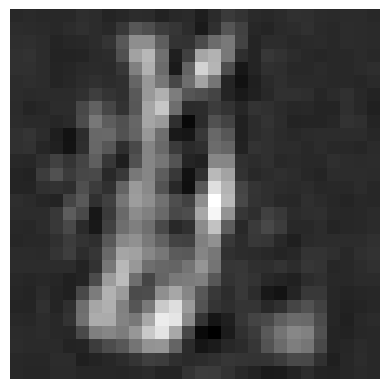

: 

In [ ]:
plt.figure()
plt.imshow(newData[241], cmap='gray')
plt.axis('off')

# Bottleneck layer tuning
While increasing the number of bottleneck layer nodes continuously gives better performance, the point of the SAE is to create a latent space that is much smaller than the original dimensionality, so although 300, 350, and 400 nodes all have smaller loss than 200 nodes, the loss difference is relatively minimal, so we will use XXX of 200 in the bottleneck layer since it both decreases the dimensionality greatly, and much better reconstruction performance than having 150 or fewer nodes.

In [39]:
# Perform PCA to find out how much dimensionality reduction we can do
from sklearn.decomposition import PCA
expVar1 = 0.95
expVar2 = 0.99
expVar3 = 0.999


avg_dims1 = 0
avg_dims2 = 0
avg_dims3 = 0



for iii in range(X_train.shape[0]):
    
    my_pca1 = PCA(n_components = expVar1)
    my_pca2 = PCA(n_components = expVar2)
    my_pca3 = PCA(n_components = expVar3)

    my_pca1.fit(X_train[iii,:,:])
    my_pca2.fit(X_train[iii,:,:])
    my_pca3.fit(X_train[iii,:,:])
    
    avg_dims1 = avg_dims1 + len(my_pca1.explained_variance_ratio_)
    avg_dims2 = avg_dims2 + len(my_pca2.explained_variance_ratio_)
    avg_dims3 = avg_dims3 + len(my_pca3.explained_variance_ratio_)
    
avg_dims1 = avg_dims1 / X_train.shape[0]
avg_dims2 = avg_dims2 / X_train.shape[0]
avg_dims3 = avg_dims3 / X_train.shape[0]

In [40]:
print(avg_dims1)
print(avg_dims2)
print(avg_dims3)

7.1459375
11.061916666666667
15.506791666666667


In [48]:
# Train 3 autoencoders with these bottleneck layers and see the results
lr = 0.001
B1 = 0.9
B2 = 0.999
bottleneck1 = 8
bottleneck2 = 12
bottleneck3 = 16

encoder1 = models.Sequential([
    layers.Flatten(input_shape=[28,28]),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(bottleneck1,  activation='relu', use_bias=False)
])

encoder2 = models.Sequential([
    layers.Flatten(input_shape=[28,28]),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(bottleneck2,  activation='relu', use_bias=False)
])

encoder3 = models.Sequential([
    layers.Flatten(input_shape=[28,28]),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(bottleneck3,  activation='relu', use_bias=False)
])

decoder1 = models.Sequential([
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(28*28, use_bias=False),
    layers.Reshape([28, 28])
])

decoder2 = models.Sequential([
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(28*28, use_bias=False),
    layers.Reshape([28, 28])
])

decoder3 = models.Sequential([
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(28*28, use_bias=False),
    layers.Reshape([28, 28])
])

autoencoder1 = models.Sequential([encoder1, decoder1])
autoencoder2 = models.Sequential([encoder2, decoder2])
autoencoder3 = models.Sequential([encoder3, decoder3])

autoencoder1.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                    optimizer=optimizers.Adam(learning_rate=lr,
                    beta_1=B1,
                    beta_2=B2))

autoencoder2.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                    optimizer=optimizers.Adam(learning_rate=lr,
                    beta_1=B1,
                    beta_2=B2))

autoencoder3.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                    optimizer=optimizers.Adam(learning_rate=lr,
                    beta_1=B1,
                    beta_2=B2))

In [49]:
# training
callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history1 = autoencoder1.fit(X_train, X_train, epochs=100, 
                    validation_data=(X_val, X_val),
                    callbacks=callback1)

history2 = autoencoder2.fit(X_train, X_train, epochs=100, 
                    validation_data=(X_val, X_val),
                    callbacks=callback1)

history3 = autoencoder3.fit(X_train, X_train, epochs=100, 
                    validation_data=(X_val, X_val),
                    callbacks=callback1)

Epoch 1/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0774 - val_loss: 0.0705
Epoch 2/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0670 - val_loss: 0.0649
Epoch 3/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0634 - val_loss: 0.0627
Epoch 4/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0614 - val_loss: 0.0614
Epoch 5/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0592 - val_loss: 0.0589
Epoch 6/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0573 - val_loss: 0.0574
Epoch 7/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0560 - val_loss: 0.0568
Epoch 8/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0551 - val_loss: 0.0560
Epoch 9/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0543 - val_loss: 0.0557
Epoch 10/100
1500/1500 [==============================] - 2s 1ms/step - l

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_51 (Sequential)   (None, 16)                790400    
_________________________________________________________________
sequential_54 (Sequential)   (None, 28, 28)            790400    
Total params: 1,580,800
Trainable params: 0
Non-trainable params: 1,580,800
_________________________________________________________________


In [51]:
# # Design an MLP classifier
# MLPClassifier = models.Sequential([
#     layers.Dense(400,  activation='relu', use_bias=False),
#     layers.Dense(600,  activation='relu', use_bias=False),
#     layers.Dense(800,  activation='relu', use_bias=False),
#     layers.Dense(10,  activation='softmax', use_bias=False)
# ])

# Keeping 99.9% of the variance with only 16 features in the bottleneck layer is a great tradeoff, and the loss was not bad in training

# Freeze the autoencoder3 for use in classification
for layer in autoencoder3.layers:
    layer.trainable = False
    
autoOut = autoencoder3.layers[-2].output

x = layers.Dense(450, activation='relu')(autoOut)  # MLP hidden layer
x = layers.Dense(128, activation='relu')(x)  # Another hidden layer
classifier_output = layers.Dense(10, activation='softmax')(x)

model_with_classifier = models.Model(inputs=autoencoder3.input, outputs=classifier_output)

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='flatten_20_input'), name='flatten_20_input', description="created by layer 'flatten_20_input'") at layer "flatten_20". The following previous layers were accessed without issue: []

784

# Custom Loss Function
There are many possible loss functions for classification. However, for this project we have been given the template of using a distance formulation as such: $ R = 1/K\sum_{i=1}^{K} d_i $. We can make modifications to the lambda value that we multiply by R, the distance metric, the batch size K, and other implementation criteria. We will try euclidean distance (with latent space normalization), as well as a Manhattan block distance, and Chebyshev distances.

In [ ]:
# custom SAE loss
from sklearn.preprocessing import StandardScaler

class StackedAutoencoderLoss(tf.keras.losses.Loss):
    def __init__(self, lam=0.5, name="stacked_autoencoder_loss", distance_type = 'l2', prior_dir='sparse'):
        """
        Initialize the loss class.

        Args:
            lam (float): Weighting factor for the custom latent space loss component.
            name (str): Name of the loss.
            distance_type (str): one of 'l1', 'l2', or 'linf' describing the three distance types
            prior_dir (str): either 'sparse' for a sparse encoding or 'dense' for a Gram Schmidt dense matrix
        """
        super().__init__(name=name)
        self.lam = lam
        self.distance_type = distance_type
        self.prior_dir = prior_dir
        

    def call(self, y_true, y_pred, latent_space=None, prior=None):
        if prior is None:
            raise ValueError("Prior argument is required.")
        
        if latent_space is None:
            raise ValueError("Latent space argument is required.")
        """
        Compute the combined loss.

        Args:
            y_true (Tensor): Tensor of true input values for reconstruction (e.g., autoencoder input).
            y_pred (Tensor): Tensor of reconstructed values (autoencoder output).
            latent_space (Tensor): Tensor representing the latent space embeddings.
            prior (Int): Integer of the for the input's class.
         

        Returns:
            A scalar Tensor representing the combined loss value.
        """
        # print(f"y_true shape: {y_true.shape}")
        # print(f"y_pred shape: {y_pred.shape}")
        # print(f"latent_space shape: {latent_space.shape}")
        # print(f"prior shape: {prior.shape}")
        
        # Get batch size
        batch_size = tf.shape(y_true)[0]
        
        # Get latent_space and prior length
        latent_dim = latent_space.shape[-1]
        num_classes = 10
        
        # Reconstruction loss (MSE) across all elements in the batch
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred), axis=(1, 2, 3))  # Adjust axes for your data shape

        # Make prior direction
        if self.prior_dir == 'sparse':
            prior_directions = self.generate_orthogonal_directions(num_classes, latent_dim)
            
        elif self.prior_dir == 'dense':
            prior_directions = self.generate_dense_orthogonal_directions(num_classes, latent_dim)
            
        else:
            raise ValueError("Prior direction may only be 'dense' or 'sparse'.")
        
        # Get the distance measure
        selected_prior_direction = prior_directions[prior, :]

        # Compute latent space distance based on the specified metric
        if self.distance_type == 'l1':
            # L1 distance: Sum of absolute differences
            latent_loss = tf.reduce_mean(tf.abs(latent_space - selected_prior_direction), axis=1)
        elif self.distance_type == 'l2':
            # L2 distance: Euclidean distance (squared differences)
            latent_loss = tf.reduce_mean(tf.square(latent_space - selected_prior_direction), axis=1)
        elif self.distance_type == 'linf':
            # Linf distance: Maximum absolute difference
            latent_loss = tf.reduce_max(tf.abs(latent_space - selected_prior_direction), axis=1)
        else:
            raise ValueError("Distance type must be 'l1', 'l2', or 'linf'.")
        

        # Latent space loss (e.g., L2 distance to prior)
        latent_loss = latent_loss / tf.cast(batch_size, tf.float32)

        # Combine both losses per sample in the batch
        total_loss = (self.lam * mse_loss) + ((1- self.lam) * latent_loss)

        # Average over the batch
        return tf.reduce_mean(total_loss)
    
    def generate_dense_orthogonal_directions(self, num_classes, latent_dim, seed=10):
        """
        Generate dense orthogonal target directions using Gram-Schmidt process.

        Args:
            num_classes (int): Number of classes.
            latent_dim (int): Dimensionality of the latent space.

        Returns:
            np.ndarray: Array of shape (num_classes, latent_dim) containing dense orthogonal unit vectors.
        """
        if num_classes > latent_dim:
            raise ValueError("Number of classes cannot exceed latent space dimensionality.")

        np.random.seed(seed)
        # Start with random vectors
        random_vectors = np.random.randn(num_classes, latent_dim)

        # Apply Gram-Schmidt process to orthogonalize
        orthogonal_vectors = []
        for v in random_vectors:
            for u in orthogonal_vectors:
                v -= np.dot(v, u) * u  # Subtract projection
            v = v / np.linalg.norm(v)  # Normalize
            orthogonal_vectors.append(v)
        
        return np.array(orthogonal_vectors)
    
    def generate_orthogonal_directions(self, num_classes, latent_dim):
        """
        Generate orthogonal target directions in latent space.

        Args:
            num_classes (int): Number of classes.
            latent_dim (int): Dimensionality of the latent space.

        Returns:
            np.ndarray: Array of shape (num_classes, latent_dim) containing orthogonal unit vectors.
        """
        if num_classes > latent_dim:
            raise ValueError("Number of classes cannot exceed latent space dimensionality.")

        # Start with an identity matrix for orthogonal vectors
        identity_matrix = np.eye(latent_dim)

        # Select the first num_classes rows
        target_directions = identity_matrix[:num_classes]

        return target_directions
    

# Training with New Loss Functions


In [23]:
from tensorflow.keras import datasets, layers, models, optimizers, losses, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 32  # Example batch size

# Create the training dataset with class labels
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, t_train))  # Pair images with labels
train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size=1000)

# Create the validation dataset with class labels
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, t_val))  # Pair images with labels
val_dataset = val_dataset.batch(batch_size)

bottleneckNum  = 200
lr = 0.0005
B1 = 0.875
B2 = 0.997

encoder = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneckNum,  activation='relu', use_bias=False)
        ])

decoder = models.Sequential([
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(28*28, use_bias=False),
    layers.Reshape([28, 28])
])

# Custom Training Loop
class CustomAutoencoder(tf.keras.Model):
    def __init__(self, encoder, decoder, loss_fn):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.loss_fn = loss_fn

    def call(self, x):
        latent_space = self.encoder(x)
        y_pred = self.decoder(latent_space)
        return y_pred, latent_space
    
loss_fn = StackedAutoencoderLoss(lam=0.5, distance_type = 'l2', prior_dir='dense')

# Create the autoencoder with encoder, decoder
autoencoder_model = CustomAutoencoder(encoder, decoder, loss_fn)

# Optimizer same as the best from before
optimizer = optimizers.Adam(learning_rate=lr, beta_1=B1, beta_2=B2)

# Custom Training Step
@tf.function
def train_step(x, class_labels, model, loss_fn, optimizer):
    with tf.GradientTape() as tape:
        y_pred, latent_space = model(x)  # Forward pass
        # Check if y_pred or latent_space is a tuple
        class_labels = tf.reshape(class_labels, (-1, 1))
        
        # print(f"x shape: {x.shape}")
        # print(f"class_labels shape: {class_labels.shape}")
        # print(f"y_pred shape: {y_pred.shape}")
        # print(f"latent_space shape: {latent_space.shape}")
        
        # Pass class_labels as prior to the loss function
        loss_value = loss_fn(x, y_pred, latent_space, class_labels)  # Corrected call to loss_fn with 4 arguments
    grads = tape.gradient(loss_value, model.trainable_variables)  # Compute gradients
    optimizer.apply_gradients(zip(grads, model.trainable_variables))  # Apply gradients
    return loss_value



# Training Loop with validation loss tracking
def train(train_dataset, val_dataset, epochs, model, optimizer, loss_fn):
    best_val_loss = float('inf')  # Track the best validation loss
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Training phase
        for x_batch, class_labels in train_dataset:
            loss_value = train_step(x_batch, class_labels, model, loss_fn, optimizer)  # Train step
            print(f"Training Loss: {loss_value.numpy()}")
        
        # Validation phase (compute the validation loss)
        val_loss = 0
        for x_batch_val, class_labels_val in val_dataset:
            y_pred_val, latent_space_val = model(x_batch_val)  # Forward pass
            val_loss += loss_fn(x_batch_val, y_pred_val, latent_space_val, class_labels_val).numpy()
        
        # Calculate average validation loss over the validation dataset
        val_loss /= len(val_dataset)
        print(f"Validation Loss: {val_loss}")
        
        # Save the best model weights based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            model.set_weights(model.get_weights())  # Save the best model weights
            print("Best model weights saved!")

    print("Training completed!")


# Start training with validation loss tracking
train(train_dataset, val_dataset, epochs=100, model=autoencoder_model, optimizer=optimizer, loss_fn=loss_fn)

Epoch 1/100


TypeError: in user code:

    C:\Users\jarod\AppData\Local\Temp\ipykernel_15640\4248445822.py:68 train_step  *
        loss_value = loss_fn(x, y_pred, latent_space, class_labels)  # Corrected call to loss_fn with 4 arguments

    TypeError: __call__() takes from 3 to 4 positional arguments but 5 were given
